<center><font color="lightbeige" size=+1.0><b>Data feature selection / extraction using SCI-XAI pipeline</b></font><center>

<font color="bluegrey" size=+1.0><b>Load and Read dataset</b></font>

In [4]:
import pandas as pd

# Load the dataset
f_path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(f_path)

print("Data Summary")
print(df.describe())
print("\nMissing Values")
print(df.isnull().sum())

Data Summary
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33

<font color="bluegrey" size=+1.0><b>Handling missing data</b></font>

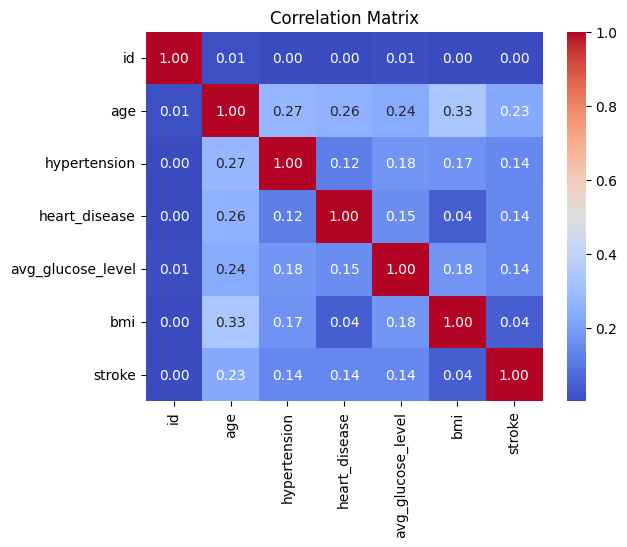

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['bmi'].replace('N/A', np.nan, inplace=True)
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

df.dropna(inplace=True)

# numeric columns
numeric_columns = df.select_dtypes(include=np.number)

# Visualize correlations
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<font color="bluegrey" size=+1.0><b>Standardisation</b></font>

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_values = scaler.fit_transform(numeric_columns)

# Converts scaled values back to DataFrame
df_scaled = pd.DataFrame(scaled_values, columns=numeric_columns.columns)

# Concatenates non-numeric columns with the scaled numeric columns
non_numeric_columns = df.drop(columns=numeric_columns.columns)
df_scaled = pd.concat([non_numeric_columns, df_scaled], axis=1)

<font color="bluegrey" size=+1.0><b>SCI-XAI pipeline and feature selection</b></font>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


selected_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
X = pd.get_dummies(df[selected_features], columns=['smoking_status'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection using Gradient Boosting for stroke prediction
model_gradient_boosting = GradientBoostingClassifier(random_state=42)
model_gradient_boosting.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

<font color="bluegrey" size=+1.0><b>Data exploration</b></font>

In [8]:
print("Selected Features:")
print(selected_features)

# Display summary statistics of the selected features
print(df[selected_features].describe())

Selected Features:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
               age  hypertension  heart_disease  avg_glucose_level  \
count  4909.000000   4909.000000    4909.000000        4909.000000   
mean     42.865374      0.091872       0.049501         105.305150   
std      22.555115      0.288875       0.216934          44.424341   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.070000   
50%      44.000000      0.000000       0.000000          91.680000   
75%      60.000000      0.000000       0.000000         113.570000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi  
count  4909.000000  
mean     28.893237  
std       7.854067  
min      10.300000  
25%      23.500000  
50%      28.100000  
75%      33.100000  
max      97.600000  


<font color="bluegrey" size=+1.0><b>XAI techniques - LIME, SHAP and Anchor</b></font>

c:\Users\zen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


LIME Explanation:


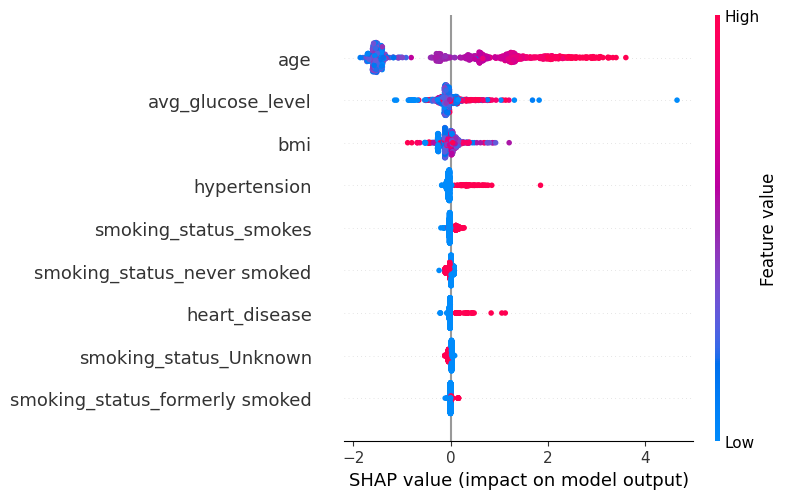

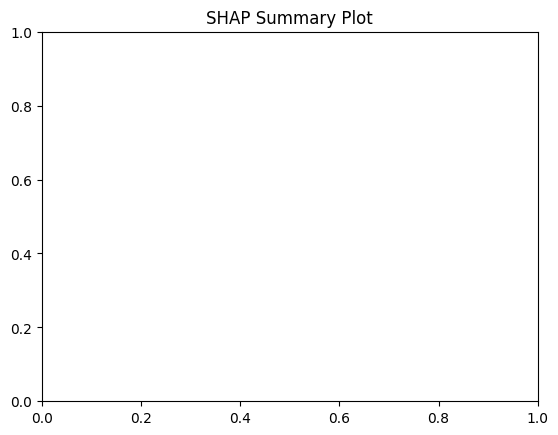

   gender  hypertension  heart_disease ever_married      work_type  \
0    Male             0              1          Yes        Private   
2    Male             0              1          Yes        Private   
3  Female             0              0          Yes        Private   
4  Female             1              0          Yes  Self-employed   
5    Male             0              0          Yes        Private   

  Residence_type   smoking_status  
0          Urban  formerly smoked  
2          Rural     never smoked  
3          Urban           smokes  
4          Rural     never smoked  
5          Urban  formerly smoked  


IndexError: list index out of range

In [9]:
import shap
import random
import matplotlib.pyplot as plt
from lime import lime_tabular
from anchor import anchor_tabular
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# LIME for explaining individual predictions
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode='classification', feature_names=X_train.columns.to_list())
instance_to_explain = X_test.iloc[0]
lime_explanation = lime_explainer.explain_instance(instance_to_explain.values, model_gradient_boosting.predict_proba)
print("LIME Explanation:")
print(lime_explanation)

# SHAP for feature importance
explainer = shap.TreeExplainer(model_gradient_boosting)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.to_list())
plt.title('SHAP Summary Plot')
plt.show()

# Instance plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], instance_to_explain, feature_names=X_test.columns.to_list())

class_names = ['No Stroke', 'Stroke']

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'avg_glucose_level', 'bmi']

feature_names = categorical_features + numerical_features

# Defines df_categorical containing the categorical features
df_categorical = df[categorical_features].copy()

# Verify df_categorical
print(df_categorical.head())

# Encode categorical features
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_categorical[feature] = label_encoders[feature].fit_transform(df_categorical[feature])

one_hot_encoder = OneHotEncoder()
X_categorical_encoded = one_hot_encoder.fit_transform(df_categorical[categorical_features]).toarray()

X_encoded = np.concatenate((X_categorical_encoded, df[numerical_features].values), axis=1)
y_binary = (df['stroke'] == 1).astype(int)

feature_names_encoded = list(df_categorical.columns) + numerical_features

# Anchor test
explainer = anchor_tabular.AnchorTabularExplainer(class_names, feature_names, X_encoded, categorical_names=dict(zip(feature_names, [list(df[col].unique()) for col in df_categorical.columns])), discretizer='quartile')
explainer.fit(X_encoded, y_binary)

# Selects a random instance
idx = random.randint(0, len(X_encoded) - 1)
instance = X_encoded[idx]

# Explains the prediction using an anchor
explanation = explainer.explain_instance(instance, model_gradient_boosting.predict_proba, threshold=0.95)
print(explanation['names'])
print(explanation['precision'])
print(explanation['coverage'])